In [1]:
# Allow GPU memory growth
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [3]:
import os
import cv2
import requests
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Preparation

In [4]:
path = os.getcwd() + '/pokemon dataset'

Total number of categories: 5
Total number of images in dataset: 1469


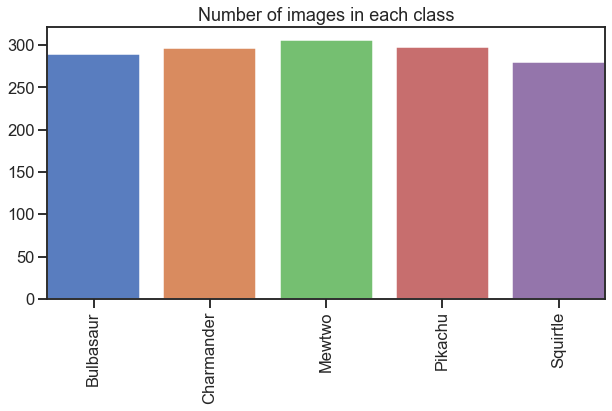

In [5]:
classes = os.listdir((path))
print(f'Total number of categories: {len(classes)}')

# Create a dictionary which contains class and number of images in that class
counts = {}
for i in classes:
    counts[i] = len(os.listdir(os.path.join(path, i)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Plot the number of images in each class
sns.set_context('talk')
sns.set_palette(sns.color_palette('muted'))
sns.set_style('ticks')

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts.keys()), y=list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [6]:
# Create dataset and sort the items in the dictionary
dataset = sorted(counts.items(), key=lambda x:x[1],reverse = True)
print(dataset)

# Extract labels
dataset = [i[0] for i in dataset]
print(dataset)

[('Mewtwo', 306), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [7]:
X = [] # Empty list for images
Y = [] # Empty list for labels

IMAGE_DIMS = (128, 128, 3) # Set image dimensions

# Loop through all classes
for c in classes:
    if c in dataset:
        dir_path = os.path.join(path, c)
        label = dataset.index(c) # the label is an index of class in data
        
        # Read, resize, add images and labels to lists
        for i in os.listdir(dir_path):
            image = cv2.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv2.resize(image,(IMAGE_DIMS[0],IMAGE_DIMS[1]))
                X.append(resized)
                Y.append(label)

            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file.')
                continue       

# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, IMAGE_DIMS[0], IMAGE_DIMS[1],IMAGE_DIMS[2])

# Scale data in array
X = X / 255.0
print(X.shape)

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(dataset))

(1469, 128, 128, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, shuffle=True, random_state=1)

### Creation of CNN using Transfer Learning 

Transfer learning is applied by freezing the "deep layers" of the model and only re-training the classification layers.

In [9]:
# Import VGG16 from keras with pre-trained weights that is trained on imagenet
# Include_top=False to exclude the top classification layer 
# weights='imagenet' to use the weights from pre-training on Imagenet

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_DIMS)

for layer in base_model.layers:
     layer.trainable = False

In [10]:
# Build the classification layers on top of the base VGG16 base layers for the dataset
model = tf.keras.Sequential(base_model.layers)

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(len(dataset), activation = 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

### Train the Model

Use the "transferred" VGG16 model to train on the dataset.

In [11]:
initial_epochs = 8
initial_batch_size = 32

In [12]:
# Enable run function eagerly to use function decorator
tf.config.experimental_run_functions_eagerly(True)

checkpoint_filepath = 'Pokemon_model.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, 
                                                               monitor='val_accuracy', mode='max', save_best_only=True)

# Save only the best model weights at the end of every epoch
history = model.fit(X_train, y_train, validation_split=0.2, epochs=initial_epochs, 
                    batch_size=initial_batch_size, verbose=1, 
                    callbacks=[model_checkpoint_callback])

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

Epoch 1/8
30/30 [==============================] - 36s 1s/step - loss: 1.2045 - accuracy: 0.5553 - val_loss: 0.8769 - val_accuracy: 0.7106
Epoch 2/8
30/30 [==============================] - 32s 1s/step - loss: 0.5594 - accuracy: 0.8074 - val_loss: 0.4620 - val_accuracy: 0.8511
Epoch 3/8
30/30 [==============================] - 32s 1s/step - loss: 0.3582 - accuracy: 0.8734 - val_loss: 0.3925 - val_accuracy: 0.8723
Epoch 4/8
30/30 [==============================] - 30s 1s/step - loss: 0.2269 - accuracy: 0.9234 - val_loss: 0.3276 - val_accuracy: 0.8936
Epoch 5/8
30/30 [==============================] - 28s 923ms/step - loss: 0.1909 - accuracy: 0.9330 - val_loss: 0.3125 - val_accuracy: 0.9064
Epoch 6/8
30/30 [==============================] - 27s 890ms/step - loss: 0.1765 - accuracy: 0.9426 - val_loss: 0.2976 - val_accuracy: 0.8979
Epoch 7/8
30/30 [==============================] - 27s 898ms/step - loss: 0.1360 - accuracy: 0.9564 - val_loss: 0.2927 - val_accuracy: 0.9106
Epoch 8/8
10/10 [=

### Learning Curves

Plot learning curves of the training and validation accuracy/ loss when using the "transferred" VGG16 base model.

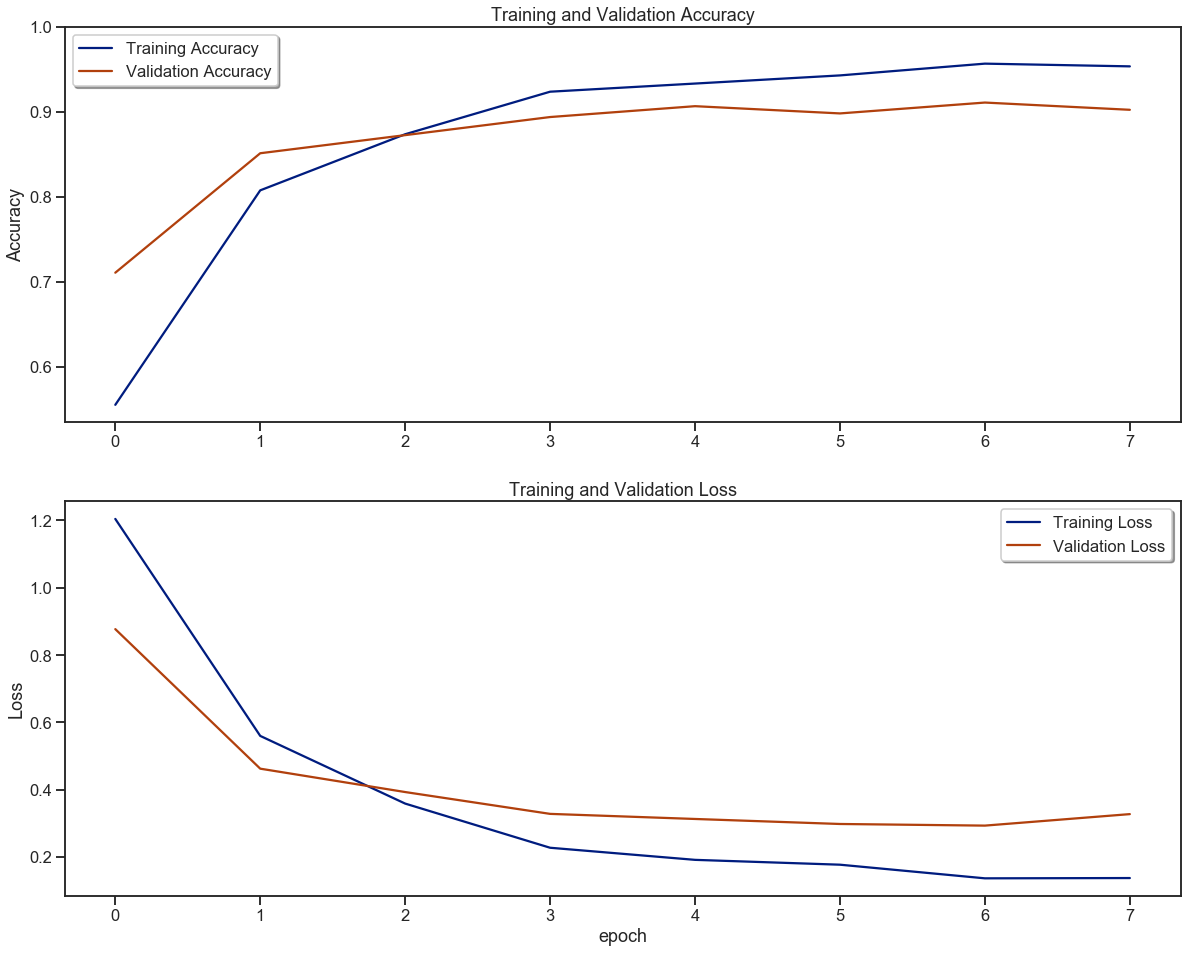

In [13]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best', shadow=True)
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='best', shadow=True)
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-Tuning of CNN model 

Fine-tune and compile the model using a much lower learning rate.

In [14]:
base_model = tf.keras.applications.VGG16(include_top=False, weights=None)

# The model weights (that are considered the best) are loaded into the model
model.load_weights(checkpoint_filepath) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

Continue training the model to improve the test accuracy and test loss.

In [15]:
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

final_batch_size = 8

history_fine = model.fit(X_train, y_train, validation_split=0.2, epochs=total_epochs, 
                         initial_epoch= history.epoch[-1], batch_size=final_batch_size, verbose=1)

test_loss_ft, test_acc_ft = model.evaluate(X_test, y_test, verbose=1)
print('test_loss_fine_tuned:', test_loss_ft)
print('test_acc_fine_tuned:', test_acc_ft)

Epoch 8/15
118/118 [==============================] - 54s 459ms/step - loss: 0.2586 - accuracy: 0.9128 - val_loss: 0.3037 - val_accuracy: 0.9021
Epoch 9/15
118/118 [==============================] - 50s 425ms/step - loss: 0.2427 - accuracy: 0.9255 - val_loss: 0.3091 - val_accuracy: 0.8936
Epoch 10/15
118/118 [==============================] - 48s 408ms/step - loss: 0.2620 - accuracy: 0.9138 - val_loss: 0.3059 - val_accuracy: 0.8979
Epoch 11/15
118/118 [==============================] - 50s 425ms/step - loss: 0.2943 - accuracy: 0.9032 - val_loss: 0.2863 - val_accuracy: 0.9021
Epoch 12/15
118/118 [==============================] - 48s 410ms/step - loss: 0.2748 - accuracy: 0.9011 - val_loss: 0.2729 - val_accuracy: 0.9021
Epoch 13/15
118/118 [==============================] - 50s 422ms/step - loss: 0.2267 - accuracy: 0.9181 - val_loss: 0.2616 - val_accuracy: 0.9191
Epoch 14/15
118/118 [==============================] - 49s 419ms/step - loss: 0.2379 - accuracy: 0.9117 - val_loss: 0.2794 - v

### Learning Curves after fine tuning

Plot learning curves of the training and validation accuracy/ loss after fine tuning.

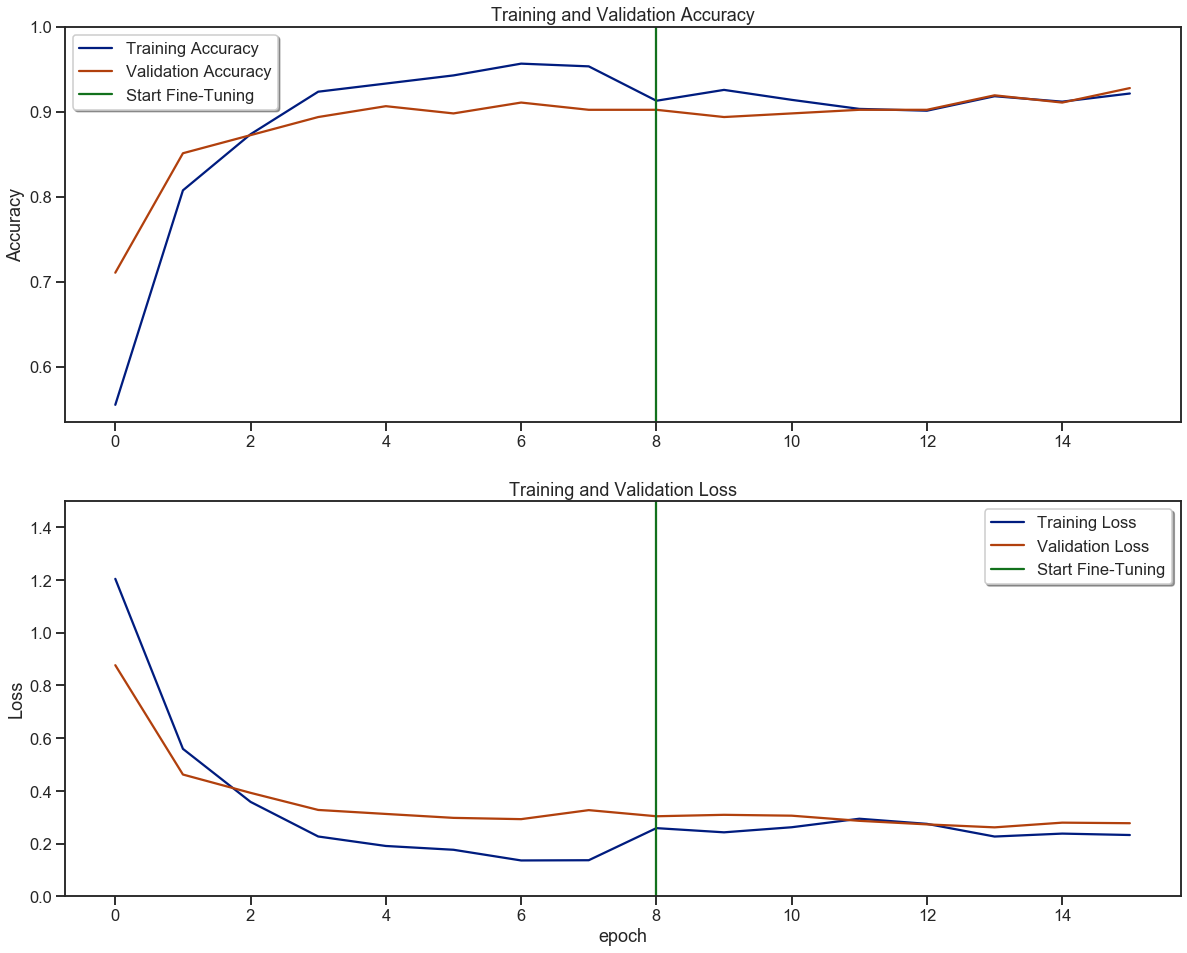

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(20, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='best', shadow=True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.ylabel('Loss')
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='best', shadow=True)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning has helped to improve the validation accuracy.

## Evaluation of Results

In [17]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/6087/2437349-pikachu.png',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://cdn.vox-cdn.com/thumbor/JblVKwBfJ9BDIQJ30sfZp93QGYE=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61577305/jbareham_180925_ply0802_0024.0.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

In [18]:
# Empty lists to store our future data
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:        
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        val_x.append(image)
        val_y.append(i)

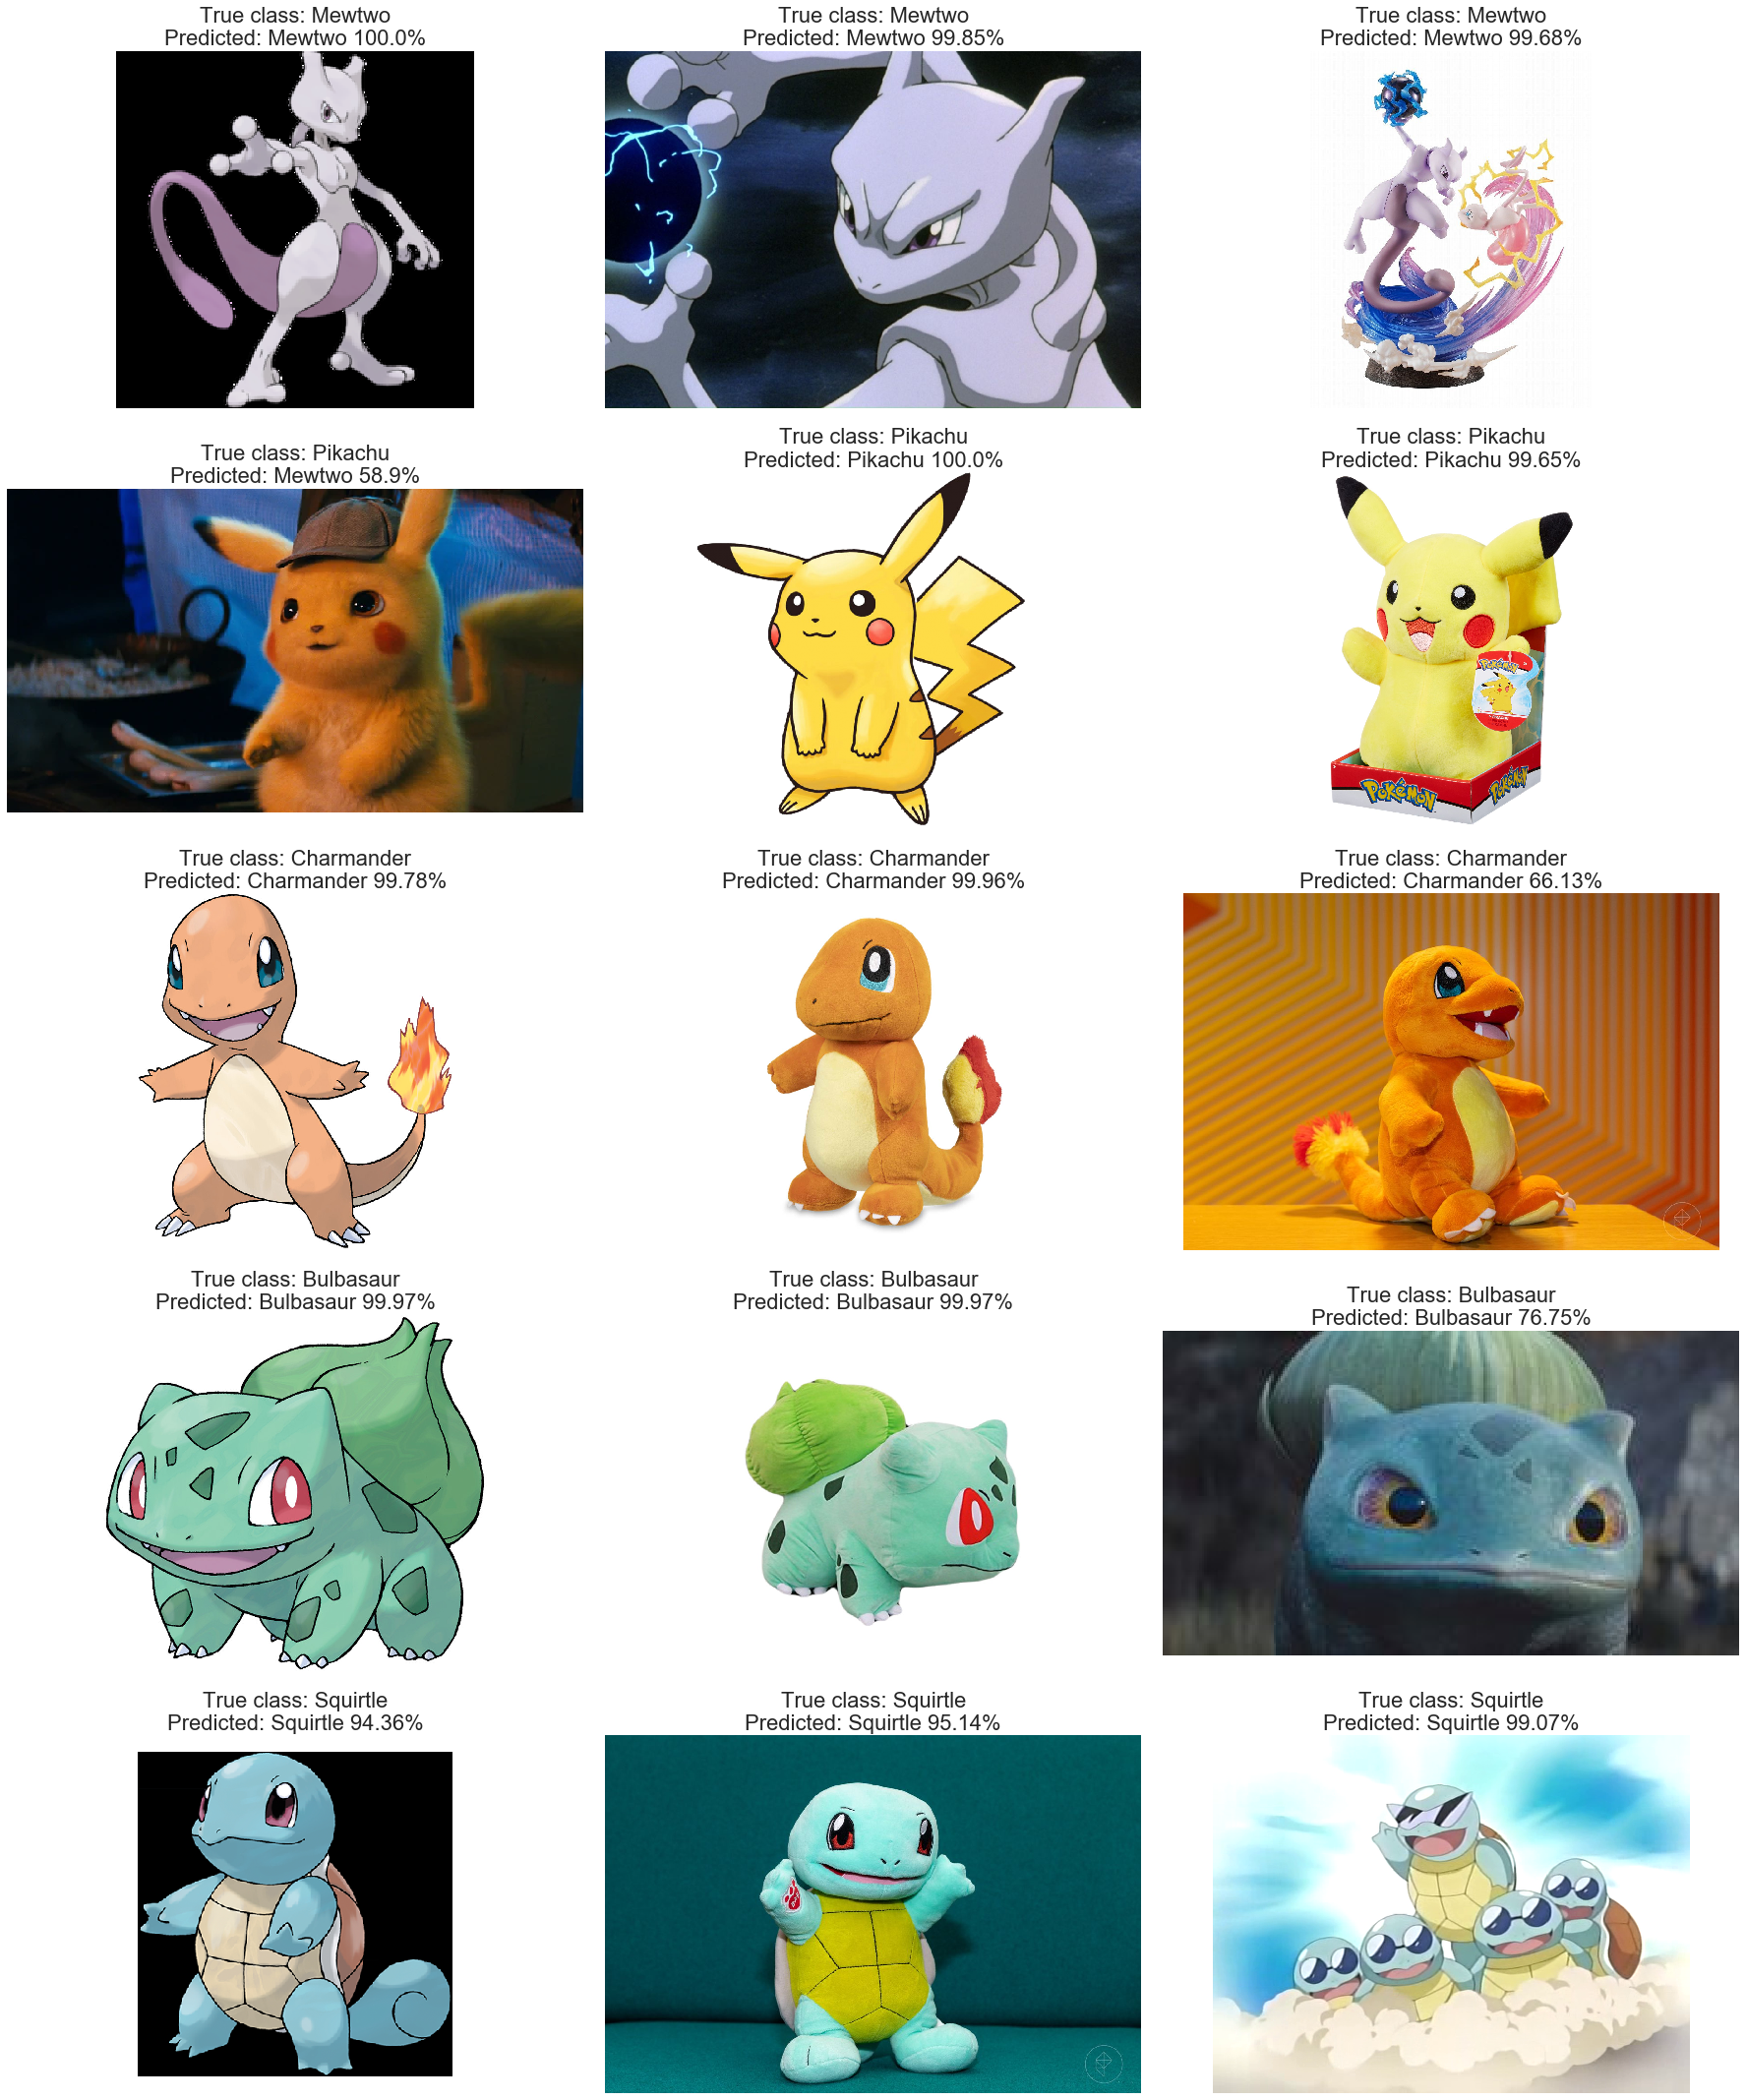

In [19]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 30))

for i, j in enumerate(zip(val_x, val_y)): # i - for subplots
    orig = j[0] # Original, not resized image
    label = j[1] # Label for that image
    
    image = cv2.resize(orig, (IMAGE_DIMS[0], IMAGE_DIMS[1])) # Resize image
    image = image.reshape(-1, IMAGE_DIMS[0], IMAGE_DIMS[1],IMAGE_DIMS[2])/255.0 # Reshape and scale resized image
    preds = model.predict(image) # Predict image
    pred_class = np.argmax(preds) # Define predicted class
    
    true_label = f'True class: {dataset[label]}'
    pred_label = f'Predicted: {dataset[pred_class]} {round(preds[0][pred_class]*100, 2)}%'
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}', fontsize=22)
    plt.axis('off')
    
plt.tight_layout()